# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
MODEL_DIR = BASE_DIR + 'models/'
PRED_DIR = BASE_DIR + 'predictions/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


In [ ]:
!pip install transformers

# Imports

In [ ]:
import numpy as np
from numpy.random import seed
from tensorflow import keras, random
from sklearn.utils import shuffle
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, f1_score, precision_score, recall_score, multilabel_confusion_matrix
from transformers import *
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertConfig
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import metrics
from tensorflow.keras import layers
import pickle
# custom imports
from utils import getComments, train_val_split
from preprocessing import Preprocessor
from embeddings import load_glove_vectors, load_fasttext_vectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# utils
____________________

In [ ]:
def print_confusion_matrix(y_true, y_pred):
  print('\nConfusion matrices:')
  i = 0
  for cm in multilabel_confusion_matrix(y_true, y_pred, samplewise=False):
    if i != 0:
      print(labels[i])
    print(cm)
    i = i+1

labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
labels_perf = ['Model', 'Performance', 'Value']

# Setup

In [ ]:
### SETTINGS ###
settings = {
      'RANDOM_STATE': 42,
      'EMBEDDING_CHOICE': 'fasttext', # 'fasttext', 'glove'
      'SOURCES': ['de', 'fr', 'es'], # ['de', 'fr', 'es', 'syn_0', 'syn_1', 'syn_2'], use [] to keep only original data 
      'TEST_SIZE': 0.2,
      'UNDERSAMPLE': False
}
# set seeds
seed(settings['RANDOM_STATE'])
random.set_seed(settings['RANDOM_STATE'])
# shortcut
labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']
targets = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate', 'is_toxic']

# Load data

In [ ]:
# load train
if settings['UNDERSAMPLE']:
  train = pd.read_csv(DATA_DIR + 'train_aug_und_cleaned.csv', sep='\t')
else:
  train = pd.read_csv(DATA_DIR + 'train_aug_cleaned.csv', sep='\t')

# load test
test = pd.read_csv(DATA_DIR + 'test_cleaned.csv', sep='\t')

# load test labels
test_labels = pd.read_csv(DATA_DIR + 'test_labels_cleaned.csv', sep='\t')

# Split data in training and validation

In [ ]:
# split in train and validation
X_train_2, X_val_2, y_train_2, y_val_2 = train_val_split(X = train[train['is_toxic']==1],
                                                          targets=targets,
                                                          val_size=settings['TEST_SIZE'],
                                                          random_state=settings['RANDOM_STATE'], 
                                                          sources=settings['SOURCES'])

y_train_2 = np.array(y_train_2[labels], dtype='int32')
y_val_2 = np.array(y_val_2[labels], dtype='int32')

y_test_2 = test_labels[test_labels['is_toxic']==1][labels]
X_test_2 = test.loc[y_test_2.index, 'comment_text'] 
y_test_2 = np.array(y_test_2 , dtype='int32')

Augmenting with de ...
Augmenting with fr ...
Augmenting with es ...


# Prepare input for bert model

In [ ]:
def bertTokenize(docs, tokenizer):
  input_ids = []
  attention_masks = []
  for doc in docs:
    bert_inp = tokenizer.encode_plus(doc, add_special_tokens = True, max_length = 100, padding = 'max_length', return_attention_mask = True, truncation=True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])
  return np.array(input_ids, dtype='int32'), np.array(attention_masks, dtype='int32')

Load tokenizer from the pretrained distilbert model

In [ ]:
bert_tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

In [ ]:
# train
input_ids_train, attention_masks_train = bertTokenize(X_train_2.values, bert_tokenizer)
# val
input_ids_val, attention_masks_val = bertTokenize(X_val_2.values, bert_tokenizer)
# test
input_ids_test, attention_masks_test = bertTokenize(X_test_2.values, bert_tokenizer)

# Bert based model

## Create model

Define DistilBert configuration

In [ ]:
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False

Load pretrained bert model

In [ ]:
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Transfer learning of Bert model

In [ ]:
# define inputs
input_ids_in = Input(shape=(100,), name='input_token', dtype='int32')
input_masks_in = Input(shape=(100,), name='masked_token', dtype='int32')

# define embedding layer with Bert weights
embedding_layer = bert_model.distilbert([input_ids_in, input_masks_in])[0]

# define lstm layer
lstm_layer = Bidirectional(LSTM(50, return_sequences=True, dropout=0.2))(embedding_layer)
# flatten with global max pool
pool = GlobalMaxPool1D()(lstm_layer)
# fully connected layers
dense = Dense(50, activation='relu')(pool)
dropout = tf.keras.layers.Dropout(0.2)(dense)

# define output layer
output = Dense(6, activation='sigmoid')(dropout)

model = Model(inputs=[input_ids_in, input_masks_in], outputs = output)

Freeze layers of the pretrained Bert model

In [ ]:
for layer in model.layers[:3]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=[metrics.Precision(), 'accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 100)     327600      distilbert[0][0]             

## Train

In [ ]:
history = model.fit([input_ids_train, attention_masks_train], y_train_2, 
                    callbacks=callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                    batch_size=128, epochs=50, validation_data=([input_ids_val,attention_masks_val], y_val_2))

Epoch 1/50
406/406 [==============================] - 257s 611ms/step - loss: 0.3672 - precision: 0.7988 - accuracy: 0.8922 - val_loss: 0.2804 - val_precision: 0.8553 - val_accuracy: 0.9431
Epoch 2/50
406/406 [==============================] - 245s 605ms/step - loss: 0.2916 - precision: 0.8538 - accuracy: 0.9341 - val_loss: 0.2671 - val_precision: 0.8839 - val_accuracy: 0.9431
Epoch 3/50
406/406 [==============================] - 245s 603ms/step - loss: 0.2793 - precision: 0.8576 - accuracy: 0.9389 - val_loss: 0.2554 - val_precision: 0.8756 - val_accuracy: 0.9430
Epoch 4/50
406/406 [==============================] - 245s 603ms/step - loss: 0.2700 - precision: 0.8618 - accuracy: 0.9423 - val_loss: 0.2496 - val_precision: 0.8557 - val_accuracy: 0.9427
Epoch 5/50
406/406 [==============================] - 245s 603ms/step - loss: 0.2623 - precision: 0.8637 - accuracy: 0.9415 - val_loss: 0.2433 - val_precision: 0.8539 - val_accuracy: 0.9418
Epoch 6/50
406/406 [==============================

## Evaluation

Plot learning curves

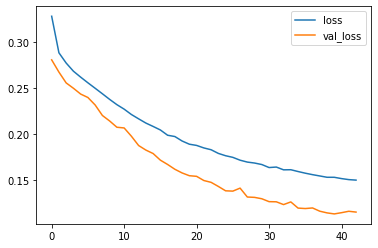

In [ ]:
pd_history = pd.DataFrame(history.history)
pd_history.plot(y=['loss', 'val_loss'])

Make predictions on the test set

In [ ]:
y_score_multi = model.predict([input_ids_test, attention_masks_test])

Assign binary value to each label to compute accuracy

In [ ]:
threshold = 0.5
y_pred_multi = [[1 if label >= threshold else 0 for label in score] for score in y_score_multi]

Measure the performance of the model

In [ ]:
print('Accuracy (vector of labels must match):', round(accuracy_score(y_test_2, y_pred_multi), 5))
print('ROC AUC:', round(roc_auc_score(y_test_2, y_score_multi, average='macro'), 5))
print('Precision:', round(precision_score(y_test_2, y_pred_multi, average='macro'), 5))
print('Recall:', round(recall_score(y_test_2, y_pred_multi, average='macro'), 5))
print('F1 score:', round(f1_score(y_test_2, y_pred_multi, average='macro'), 5))
print(print_confusion_matrix(y_test_2, y_pred_multi))

Accuracy (vector of labels must match): 0.41012
ROC AUC: 0.82176
Precision: 0.66839
Recall: 0.65951
F1 score: 0.65809

Confusion matrices:
[[   6  147]
 [ 120 5969]]
severe_toxic
[[5425  450]
 [ 199  168]]
obscene
[[1812  740]
 [ 802 2888]]
threat
[[5961   70]
 [ 121   90]]
insult
[[1910  906]
 [1027 2399]]
identity_hate
[[5324  206]
 [ 278  434]]
None


## Save model and prediction

In [ ]:
# save model
model.save(MODEL_DIR + 'bert_multi.h5')
# save predictions
y_pred_multi = pd.DataFrame(y_pred_multi, columns=labels)
y_pred_multi.to_csv(PRED_DIR + 'bert_multi.csv', index=False, sep='\t')